<a href="https://colab.research.google.com/github/mohitraosatya/Quantum-Crypto-Enhancements/blob/main/Quantum_Enhanced_Dynamic_Key_Rollover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycryptodome

import requests
import secrets
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import base64


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.6 MB/s eta 0:00:00


In [2]:
def get_quantum_random_numbers(length=16):
    """
    Attempt to fetch quantum random numbers from the ANU QRNG API.
    If the API request fails or doesn't return a successful response,
    fall back to using the secrets module.
    Returns a list of integers (0-255) of the requested length.
    """
    url = f'https://qrng.anu.edu.au/API/jsonI.php?length={length}&type=uint8'
    try:
        response = requests.get(url, timeout=10)  # timeout to prevent long waits
        if response.status_code == 200:
            data = response.json()
            if data.get('success'):
                return data['data']
            else:
                print("QRNG API did not return a successful response. Using fallback.")
        else:
            print("Failed to fetch from QRNG API, status code:", response.status_code)
    except Exception as e:
        print("Exception encountered while fetching from QRNG API:", e)

    # Fallback: Use Python's cryptographically secure randomness
    print("Using fallback: secrets module for random numbers.")
    return [secrets.randbelow(256) for _ in range(length)]

# Test fetching 16 bytes (for a 128-bit key)
quantum_bytes_test = get_quantum_random_numbers(16)
print("Test quantum random numbers:", quantum_bytes_test)


Test quantum random numbers: [9, 247, 229, 98, 129, 241, 14, 45, 54, 131, 116, 41, 202, 12, 123, 219]


In [3]:
def simulate_pqc_kem():
    """
    Simulate a post-quantum key encapsulation mechanism (KEM) process.
    Returns a simulated shared secret (32 bytes).
    In a real implementation, this would derive the secret from a PQC algorithm.
    """
    shared_secret = secrets.token_bytes(32)
    return shared_secret

# Generate the base shared secret (simulated)
base_shared_secret = simulate_pqc_kem()
print("Simulated PQC shared secret (hex):", base_shared_secret.hex())


Simulated PQC shared secret (hex): e135e4115af4451f047f3333552a27b254974a0b2b1dba9effdcbb1db60ea9e8


In [4]:
def aes_encrypt(plaintext, key):
    """
    Encrypt plaintext using AES (CBC mode) with the given key.
    Returns the IV and ciphertext (both as bytes).
    """
    cipher = AES.new(key, AES.MODE_CBC)  # Random IV is generated automatically
    ct_bytes = cipher.encrypt(pad(plaintext.encode('utf-8'), AES.block_size))
    return cipher.iv, ct_bytes

def aes_decrypt(iv, ciphertext, key):
    """
    Decrypt ciphertext using AES (CBC mode) with the given key and IV.
    Returns the plaintext string.
    """
    cipher = AES.new(key, AES.MODE_CBC, iv)
    pt = unpad(cipher.decrypt(ciphertext), AES.block_size)
    return pt.decode('utf-8')


In [5]:
def derive_dynamic_key(shared_secret, nonce):
    """
    Derives a dynamic AES key by combining:
    - The base shared secret from the simulated PQC KEM.
    - Fresh quantum randomness (same length as the shared secret).
    - A nonce (to ensure uniqueness for each message).

    The three components are concatenated and then hashed with SHA-256.
    The first 16 bytes of the hash are returned as the AES key.
    """
    # Fetch quantum random bytes equal in length to the shared secret
    quantum_random = bytes(get_quantum_random_numbers(len(shared_secret)))

    # Combine the shared secret, quantum randomness, and nonce (converted to 4 bytes)
    combined_data = shared_secret + quantum_random + nonce.to_bytes(4, 'big')

    # Derive the final key by hashing and taking the first 16 bytes (for AES-128)
    derived_key = hashlib.sha256(combined_data).digest()[:16]
    return derived_key

# Example: Derive a dynamic key with nonce 1
test_key = derive_dynamic_key(base_shared_secret, nonce=1)
print("Derived dynamic key (hex):", test_key.hex())


Failed to fetch from QRNG API, status code: 500
Using fallback: secrets module for random numbers.
Derived dynamic key (hex): fe4c5c51b8226adb9b8fee2d228a5196


Failed to fetch from QRNG API, status code: 500
Using fallback: secrets module for random numbers.
Message 1:
  Derived key (hex): 2062cd2b45e27467720a4829041f1039
  Encrypted: C/E/wjvLqSYED/o8IBR56vYbrhZKyqYb0UYxARZGWGz1uwHPRHjtK1Z5MWHXT9uh4I1gfAXc02wHnAawK6X4vOPkae627wHMpsz+cKM2DJg=
  Decrypted: Hello, this is message 1 with dynamic key rollover.
------------------------------------------------------------
Failed to fetch from QRNG API, status code: 500
Using fallback: secrets module for random numbers.
Message 2:
  Derived key (hex): 1a039674df8f901725f5ca82604f700b
  Encrypted: C32RbFT1TkMKB5bwOEfLOPFShP/UgF8QoLm8h95CQPx5JXKvbTuQr4FZKXv5lVP/vb1KfB6O1qe84VmoGnn0wIOdnWF0wEIKzBr1cjAM6fNFlidpL5k2LZfDCplaiTkg
  Decrypted: Message 2 is secured with a fresh key derived from quantum randomness.
------------------------------------------------------------
Failed to fetch from QRNG API, status code: 500
Using fallback: secrets module for random numbers.
Message 3:
  Derived key (hex): bb2ffc

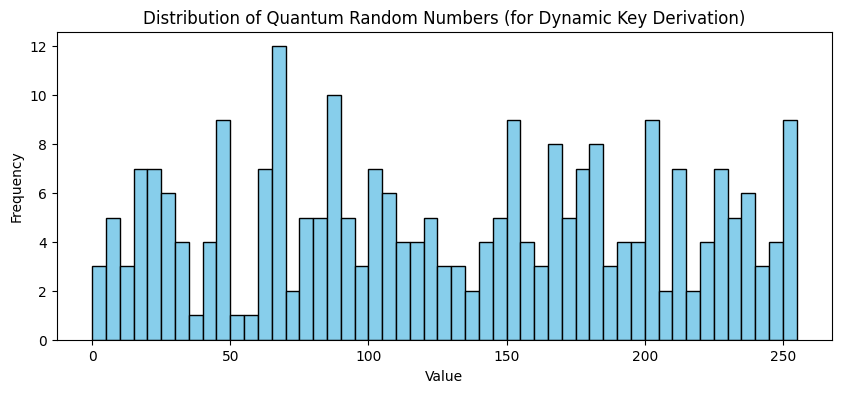

In [6]:
# Define a list of messages to simulate dynamic key rollover in secure communications
messages = [
    "Hello, this is message 1 with dynamic key rollover.",
    "Message 2 is secured with a fresh key derived from quantum randomness.",
    "Dynamic key rollover enhances security by constantly updating encryption keys.",
    "This is message 4, encrypted with a quantum-enhanced key.",
    "Final message: continuous key updates mitigate long-term key compromise."
]

encrypted_messages = []
decrypted_messages = []

# For each message, derive a dynamic key with an increasing nonce, then encrypt and decrypt
for i, msg in enumerate(messages, start=1):
    # Derive a dynamic key using the base shared secret and current nonce
    dynamic_key = derive_dynamic_key(base_shared_secret, nonce=i)

    # Encrypt the message
    iv, ciphertext = aes_encrypt(msg, dynamic_key)
    encrypted = base64.b64encode(iv + ciphertext).decode()
    encrypted_messages.append(encrypted)

    # Decrypt the message
    decrypted = aes_decrypt(iv, ciphertext, dynamic_key)
    decrypted_messages.append(decrypted)

    print(f"Message {i}:")
    print("  Derived key (hex):", dynamic_key.hex())
    print("  Encrypted:", encrypted)
    print("  Decrypted:", decrypted)
    print("-" * 60)

# Optional: Visualize the distribution of quantum randomness used in dynamic key derivation
quantum_random_numbers_large = get_quantum_random_numbers(256)
plt.figure(figsize=(10, 4))
plt.hist(quantum_random_numbers_large, bins=range(0, 257, 5), color='skyblue', edgecolor='black')
plt.title("Distribution of Quantum Random Numbers (for Dynamic Key Derivation)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def dynamic_key_demo(message, nonce):
    """
    Derives a dynamic key based on a given message and nonce,
    then encrypts and decrypts the message to demonstrate the process.
    Returns the derived key, encrypted message, and decrypted message.
    """
    dynamic_key = derive_dynamic_key(base_shared_secret, nonce)
    iv, ciphertext = aes_encrypt(message, dynamic_key)
    encrypted = base64.b64encode(iv + ciphertext).decode()
    decrypted = aes_decrypt(iv, ciphertext, dynamic_key)
    return dynamic_key, encrypted, decrypted

# Create interactive widgets for user input.
message_widget = widgets.Text(
    value="Hello, Quantum World!",
    description="Message:",
    disabled=False,
    layout=widgets.Layout(width='80%')
)
nonce_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=100,
    step=1,
    description='Nonce:',
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
output_box = widgets.Output()

def update_demo(change):
    with output_box:
        clear_output()
        msg = message_widget.value
        nonce = nonce_widget.value
        key, encrypted, decrypted = dynamic_key_demo(msg, nonce)
        print("Dynamic Key (hex):", key.hex())
        print("Encrypted message (base64):", encrypted)
        print("Decrypted message:", decrypted)

# Link widget changes to the update function.
message_widget.observe(update_demo, names='value')
nonce_widget.observe(update_demo, names='value')

# Display the interactive widgets.
display(message_widget, nonce_widget, output_box)
update_demo(None)


Text(value='Hello, Quantum World!', description='Message:', layout=Layout(width='80%'))

IntSlider(value=1, description='Nonce:', min=1)

Output()